In [37]:
#imports
import seaborn as sea
import matplotlib.pyplot as plt
import pandas as pd
from fractions import Fraction
from io import StringIO
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression

In [38]:
movieReviews = pd.read_csv('dataprep/cleaned_reviews.csv', sep = ',', header = None, names = ['review_score', 'review_content'])
movieReviews = movieReviews[~movieReviews['review_score'].str.contains('\.')]
print(movieReviews['review_content'].isnull().sum())
movieReviews = movieReviews.drop(0)
print (movieReviews.shape)
movieReviews.head()


0
(109542, 2)


,review_score,review_content
2,3/5,"Crammed with dragons, set-destroying fights an..."
3,2/4,"For what it is and for whom it is intended, it..."
4,2/5,Chris Columbus returns to his comfort zone for...
5,2/5,Although the standard allegorical bases for my...
6,3/5,You don't even have to be familiar with the fi...


In [39]:
# turn fractions into percentages

# Convert decimal strings to fractions
movieReviews['review_score'] = movieReviews['review_score'].apply(lambda x: Fraction(x))

# Convert fractions to percentages
movieReviews['review_score_percentage'] = movieReviews['review_score'] * 100

movieReviews.head()

,review_score,review_content,review_score_percentage
2,3/5,"Crammed with dragons, set-destroying fights an...",60
3,1/2,"For what it is and for whom it is intended, it...",50
4,2/5,Chris Columbus returns to his comfort zone for...,40
5,2/5,Although the standard allegorical bases for my...,40
6,3/5,You don't even have to be familiar with the fi...,60


In [40]:
# Define bins and labels
bins = [19, 39, 59, 79, 99, 120]
labels = [1, 2, 3, 4, 5]

# Create a new column 'review_label' based on the specified ranges
movieReviews['review_label'] = pd.cut(movieReviews['review_score_percentage'], bins=bins, labels=labels, include_lowest=True)


movieReviews.head()

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sydneychapman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
#finding the top 50 words for each rating

# Function to preprocess text (tokenization, lowercase, and removing stopwords)
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

train_data, test_data = train_test_split(movieReviews, test_size=0.1, random_state=42)

# Display label distribution in training and test sets
print("Training Data Label Distribution:")
print(train_data['review_label'].value_counts(normalize=True))

print("\nTest Data Label Distribution:")
print(test_data['review_label'].value_counts(normalize=True))

# Get rid of punctuation and convert text to lowercase
def preprocess_text(text):
    text = text.str.replace('\W', ' ')  # Removes punctuation
    text = text.str.lower()  # Converts text to lowercase
    return text

train_data['review_content'] = preprocess_text(train_data['review_content'])
test_data['review_content'] = preprocess_text(test_data['review_content'])

# Tokenize and build vocabulary
all_words = ' '.join(train_data['review_content'])
all_words = word_tokenize(all_words)
vocabulary = set(all_words)

Training Data Label Distribution:
review_label
3    0.398019
2    0.292639
4    0.129269
1    0.099587
5    0.080486
Name: proportion, dtype: float64

Test Data Label Distribution:
review_label
3    0.392350
2    0.294839
4    0.129954
1    0.100553
5    0.082304
Name: proportion, dtype: float64


In [42]:
from collections import Counter
#Logistic regression parameters
alpha = .06

# Initiate parameters
lr_parameters_per_rating = {rating: Counter() for rating in range(1, 6)} # logistic regression per rating



for rating in range(1, 6):
    rating_data = train_data[train_data['review_label'] == rating]['review_content']
    n_rating = len(rating_data)
    
    # Count occurrences of each word in the entire column
    word_counts = Counter(' '.join(rating_data).split())
    
    for word in vocabulary:
        n_word_given_rating = word_counts[word]
        p_word_given_rating = (n_word_given_rating + alpha) / (n_rating + alpha * len(vocabulary))
        lr_parameters_per_rating[rating][word] = p_word_given_rating

In [43]:
# Logistic Regression classifier
def lr_predict_rating(review, parameters, n_rating):
    words = word_tokenize(review)
    
    # Initialize probabilities with prior probabilities
    probabilities = {rating: 1 for rating in parameters.keys()}
    
    for word in words:
        for rating, word_params in parameters.items():
            p_word_given_rating = word_params.get(word, 1 / (n_rating + alpha * len(vocabulary)))
            probabilities[rating] *= p_word_given_rating
    
    # Choose the rating with the highest probability
    predicted_rating = max(probabilities, key=probabilities.get)
    return predicted_rating

# Predict Logistic Regression ratings on the test set
test_data['lr_predicted_rating'] = test_data['review_content'].apply(lambda x: lr_predict_rating(x, lr_parameters_per_rating, len(train_data)))

# Remove rows with NaN values in 'review_label'
test_data = test_data.dropna(subset=['review_label', 'lr_predicted_rating'])

# Evaluate the Logistic Regression accuracy
lr_accuracy = accuracy_score(test_data['review_label'], test_data['lr_predicted_rating'])
print(f"\nLogistic Regression Accuracy on the test set: {lr_accuracy:.2%}")

# Display the first few rows of the test set with predictions
print("\nTest Data with Predicted Ratings:")
print(test_data[['review_label', 'lr_predicted_rating', 'review_content']].head())


Logistic Regression Accuracy on the test set: 50.88%

Test Data with Predicted Ratings:
       review_label  lr_predicted_rating  \
12419             3                    2   
111736            3                    3   
144623            3                    2   
105747            3                    2   
68003             2                    4   

                                           review_content  
12419   call it quirky or observational or shaggy, but...  
111736  there will never be another marilyn monroe or ...  
144623  is it a pointed cultural take or just a gleefu...  
105747  the twist itself particularly original. the wa...  
68003   by dint of its on-screen talent, "laggies" qua...  


In [44]:
print(classification_report(test_data['review_label'], test_data['lr_predicted_rating']))

              precision    recall  f1-score   support

           1       0.66      0.17      0.27      1091
           2       0.48      0.74      0.58      3199
           3       0.55      0.61      0.58      4257
           4       0.37      0.17      0.23      1410
           5       0.62      0.14      0.23       893

    accuracy                           0.51     10850
   macro avg       0.53      0.37      0.38     10850
weighted avg       0.52      0.51      0.47     10850



Text(0.5, 23.52222222222222, 'Predicted Label')

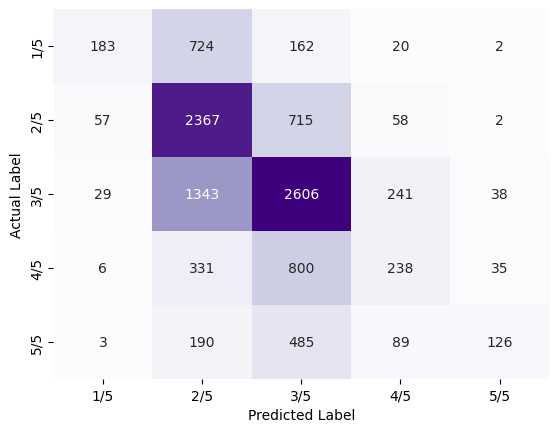

In [45]:
sea.heatmap(pd.DataFrame(confusion_matrix(test_data['review_label'], test_data['lr_predicted_rating'])), annot=True, cmap="Purples", fmt="d", cbar=False, xticklabels=['1/5', '2/5', '3/5', '4/5', '5/5'], yticklabels=['1/5', '2/5', '3/5', '4/5', '5/5'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
